In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from skimage import color
from skimage import io
from numba import jit

# 2-Dimensional Heat Transfer

General Heat Equation assuming no source/sink:

$$\nabla^2T=\frac{1}{\alpha}\frac{dT}{dt}$$

* T _is temperature_
* $\alpha$ _is the thermal diffusivity_
* t _is time_

The equation can be discreetly approximated as:

$$\left [\frac{T(t)_{x+1,y}-2T(t)_{x,y}+T(t)_{x-1,y}}{\Delta x^2}+\frac{T(t)_{x,y+1}-2T(t)_{x,y}+T(t)_{x,y-1}}{\Delta y^2}\right ]=\frac{1}{\alpha}\frac{T(t+1)_{x,y}-T(t)_{x,y}}{\Delta t}$$

Now, letting our steps in the x and y direction be equal, we can say that $\Delta y^2=\Delta x^2$

$$\frac{1}{\Delta x^2}\left[T(t)_{x+1,y}+T(t)_{x-1,y}+T(t)_{x,y+1}+T(t)_{x,y-1}-4T(t)_{x,y}\right ]=\frac{1}{\alpha}\frac{T(t+1)_{x,y}-T(t)_{x,y}}{\Delta t}$$

Solving for the future time step $T(t+1)_{x,y}$ at the current point $(x,y)$:

$$T(t+1)_{x,y}=T(t)_{x,y}+\frac{\alpha \Delta t}{\Delta x^2}\left [T(t)_{x+1,y}+T(t)_{x-1,y}+T(t)_{x,y+1}+T(t)_{x,y-1}-4T(t)_{x,y}\right ]$$

Load Image

In [2]:
img = color.rgb2gray(io.imread('3.png'))   # Read in image
img = np.flip(img, axis=0)                      # Flip to correct orientation

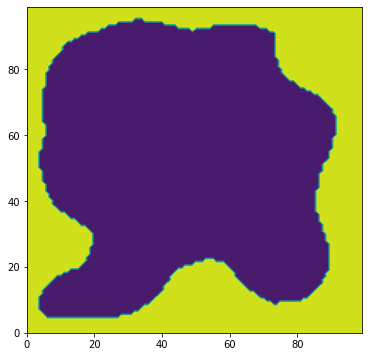

In [3]:
plt.figure(figsize=(6,6))
plt.contourf(img)

In [4]:
shape_bool = img < 0.9     # Only dark pixels are selected

Thermal diffusivity of the shape:

In [5]:
k   = 1   # Conductivity constant
rho = 1   # Density
c_p = 1   # Specific heat

#a   = k/(rho*c_p)  # Thermal diffusivity
# a   = 5.2e-7        # Brick
a   = 8.2e-8        # Wood
# a   = 4.2e-6        # 304 Stainless
# a   = 1.11e-4       # Copper
# a   = 2.32e-7       # Example value

Initial Temperatures

In [6]:
shape_temp   = 25 + 273.15    # Celcius to kelvin
ambient_temp = 165 + 273.15   # T_infinity

Set the image components to the correct initial temperatures:

In [7]:
init_heat = np.zeros([100,100]) + ambient_temp  # Set everything to ambient temp
init_heat[shape_bool] = shape_temp              # Re-set shape to initial temp

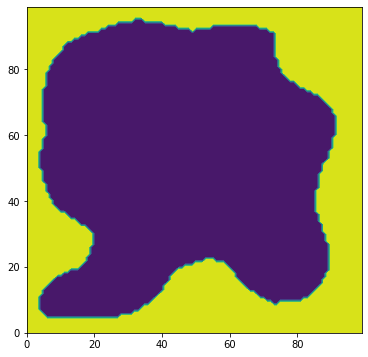

In [8]:
plt.figure(figsize=(6,6))
plt.contourf(init_heat)

Get 

* Number of differential equation update iterations `times`
* Number of individual iterations we will take `times_snapshot`
* The array of snapshots we will take of the shape

In [9]:
times = 3600             # 1hr to seconds
times_snapshot = 360     # Select every ten iterations
freq = int(times/times_snapshot)

# 3D array of individual time point snapshots of the whole image.
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat     # First layer is initial conditions

Set the dimensions of the problem

In [10]:
x  = 0.05     # Meters
dx = x/86  
dt = 1

Make sure that $\frac{\alpha \Delta t}{\Delta x^2}$ is small enough not to diverge. Must be less than 0.25

In [11]:
s = a*dt/dx**2
s

0.24258880000000002

Heat solver function

In [12]:
@jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_shape:bool):
    cs = heatmap[0].copy()  # Current state
    length = len(cs[0])
    cf = 0  # Current frame
    for t in range(1, times):   # Step time
        ns = cs.copy()   # New state
        for i in range(1, length-1):       # Step x
            for j in range(1, length-1):   # Step y
                if is_shape[j][i]:         # Only calculate for shape
                    a_n = a 
                    ns[j][i] = cs[j][i] + a_n*dt/dx**2 * (cs[j+1][i] +\
                                                          cs[j-1][i] +\
                                                          cs[j][i+1] +\
                                                          cs[j][i-1] -\
                                                          4*cs[j][i])
        cs = ns.copy()    # Advance the current state to new state
        if t%freq==0:     # We only want to record every 10th
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

Get heat snapshots (in Kelvin)

In [13]:
heat_frames = solve_heat(heat_frames, shape_bool)
heat_frames[0]

array([[438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
       [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
       [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
       ...,
       [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
       [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15],
       [438.15, 438.15, 438.15, ..., 438.15, 438.15, 438.15]])

Convert to Celcius

In [14]:
heat_frames -= 273.15

Plot the final time step heat results

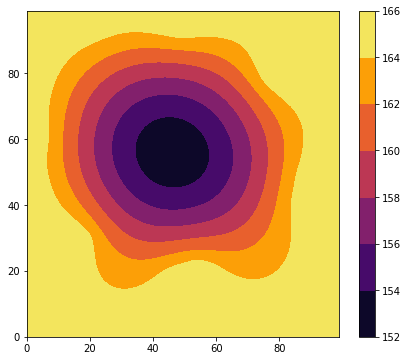

In [15]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(7,6))
# b = plt.contourf(heat_frames[-1], 1300, cmap=my_cmap, vmin=shape_temp-273.15, vmax=ambient_temp-273.15)
b = plt.contourf(heat_frames[-1],cmap=my_cmap)#, 100, cmap=my_cmap, vmin=shape_temp, vmax=ambient_temp)
plt.colorbar(b)

Make an animation

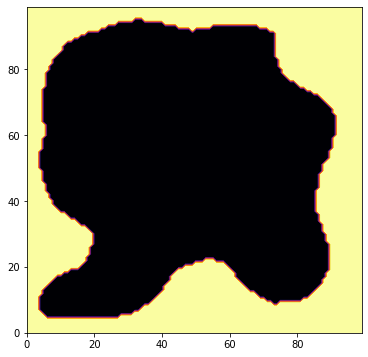

In [19]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[i], 100, cmap=my_cmap, vmin=shape_temp-273.15, vmax=ambient_temp-273.15)
    return fig,

fig, ax = plt.subplots(figsize=(6,6))
ani = animation.FuncAnimation(fig, animate, frames=times_snapshot-1, interval=50)
ani.save('animated3.gif',writer='pillow',fps=30)

Plot hourly temperature changes

In [394]:
t = np.linspace(0,10,len(heat_frames))
avg_temp = np.array([heat_frame[shape_bool].mean() for heat_frame in heat_frames])
min_temp = np.array([heat_frame[shape_bool].min() for heat_frame in heat_frames])
stdv_temp  = np.array([heat_frame[shape_bool].std() for heat_frame in heat_frames])

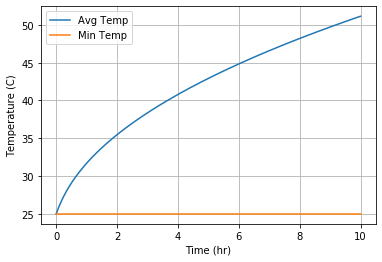

In [395]:
plt.plot(t, avg_temp, label='Avg Temp')
plt.plot(t, min_temp, label='Min Temp')
plt.ylabel('Temperature (C)')
plt.xlabel('Time (hr)')
plt.legend()
plt.grid()